# Heart Attack Study
By Kai C, Nathaniel G, Josiah L, Joseph T

## Data Preprocessing

Since the dataset file is too large, we will download the csv file (https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-united-states) and keep it in the downloads folder.

We will then import pandas and read the csv file and convert it into a dataframe.

### Import Libraries (and setting up):

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

### Read CSV file:

In [18]:
# heart_attack_df = pd.read_csv('~/Downloads/heart_attack_dataset.csv')
heart_attack_df = pd.read_csv('../heart_attack_dataset.csv')

### Remove Rows with NULL values:

In [19]:
heart_attack_df = heart_attack_df.dropna()

print("Rows: " + str(len(heart_attack_df.index)))


Rows: 372974


### Parsing:

We used one-hot encoding to changed all categorical features into binary values of 0 and 1.

In [20]:
# one-hot encoding
for_ml_heart_attack_df = heart_attack_df.copy()
for feature in heart_attack_df.columns:
    if all(isinstance(row, str) for row in for_ml_heart_attack_df[feature]): # should only do one-hot encoding if column has string values
        index = for_ml_heart_attack_df.columns.get_loc(feature)
        count = 0

        # handles edge case of features containing str yes/no values
        if for_ml_heart_attack_df[feature].iloc[0].casefold() == 'yes' or for_ml_heart_attack_df[feature].iloc[0].casefold() == 'no':
            for_ml_heart_attack_df[feature] = for_ml_heart_attack_df[feature].apply(lambda value : 1 if value.casefold() == 'yes' else 0)        
        elif feature == 'Outcome': # handles edge case of outcome feature
            for_ml_heart_attack_df[feature] = for_ml_heart_attack_df[feature].apply(lambda value : 1 if value.casefold() == 'heart attack' else 0)
        else: # creates new columns from the one-hot encoding
            dummies = pd.get_dummies(for_ml_heart_attack_df[feature], dtype=int)
            for new_col in dummies:
                # edge case features
                if feature.casefold() == 'diet' or feature.casefold() == 'chestpaintype' or feature.casefold() == 'ecgresults' or feature.casefold() == 'thalassemia' or feature.casefold() == 'thalassemia':
                    for_ml_heart_attack_df.insert(index+count, column=feature+'_'+new_col, value=dummies[new_col].values)
                # all other feaetures
                else:
                    for_ml_heart_attack_df.insert(index+count, column=new_col, value=dummies[new_col].values)
                count+=1
            
            # remove the old feature
            for_ml_heart_attack_df.drop(feature, axis=1, inplace=True)

display(for_ml_heart_attack_df.columns)
display(for_ml_heart_attack_df.head())

# features with bool True/False values
heart_attack_df['Smoker'] = heart_attack_df['Smoker'].apply(lambda value : True if value == 1 else False)
heart_attack_df['Diabetes'] = heart_attack_df['Diabetes'].apply(lambda value : True if value == 1 else False)
heart_attack_df['Hypertension'] = heart_attack_df['Hypertension'].apply(lambda value : True if value == 1 else False)
heart_attack_df['FamilyHistory'] = heart_attack_df['FamilyHistory'].apply(lambda value : True if value == 1 else False)
heart_attack_df['PreviousHeartAttack'] = heart_attack_df['PreviousHeartAttack'].apply(lambda value : True if value == 1 else False)
heart_attack_df['StrokeHistory'] = heart_attack_df['StrokeHistory'].apply(lambda value : True if value == 1 else False)

display(heart_attack_df.head())

Index(['Age', 'Female', 'Male', 'Cholesterol', 'BloodPressure', 'HeartRate',
       'BMI', 'Smoker', 'Diabetes', 'Hypertension', 'FamilyHistory',
       'PhysicalActivity', 'AlcoholConsumption', 'Diet_Healthy',
       'Diet_Moderate', 'Diet_Unhealthy', 'StressLevel', 'Asian', 'Black',
       'Hispanic', 'Other', 'White', 'Income', 'College', 'High School',
       'Postgraduate', 'Medication', 'ChestPainType_Asymptomatic',
       'ChestPainType_Atypical', 'ChestPainType_Non-anginal',
       'ChestPainType_Typical', 'ECGResults_LV hypertrophy',
       'ECGResults_Normal', 'ECGResults_ST-T abnormality', 'MaxHeartRate',
       'ST_Depression', 'ExerciseInducedAngina', 'Downsloping', 'Flat',
       'Upsloping', 'NumberOfMajorVessels', 'Thalassemia_Fixed defect',
       'Thalassemia_Normal', 'Thalassemia_Reversible defect',
       'PreviousHeartAttack', 'StrokeHistory', 'Rural', 'Suburban', 'Urban',
       'Employed', 'Retired', 'Unemployed', 'Divorced', 'Married', 'Single',
       'Widowed'

,Age,Female,Male,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,PhysicalActivity,AlcoholConsumption,Diet_Healthy,Diet_Moderate,Diet_Unhealthy,StressLevel,Asian,Black,Hispanic,Other,White,Income,College,High School,Postgraduate,Medication,ChestPainType_Asymptomatic,ChestPainType_Atypical,ChestPainType_Non-anginal,ChestPainType_Typical,ECGResults_LV hypertrophy,ECGResults_Normal,ECGResults_ST-T abnormality,MaxHeartRate,ST_Depression,ExerciseInducedAngina,Downsloping,Flat,Upsloping,NumberOfMajorVessels,Thalassemia_Fixed defect,Thalassemia_Normal,Thalassemia_Reversible defect,PreviousHeartAttack,StrokeHistory,Rural,Suburban,Urban,Employed,Retired,Unemployed,Divorced,Married,Single,Widowed,Outcome
0,31,0,1,194,162,71,22.9,0,1,0,0,6,0,0,0,1,1,0,0,1,0,0,64510,0,1,0,1,0,0,0,1,0,0,1,173,0.52,1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,69,0,1,208,148,93,33.9,1,1,0,0,1,2,0,0,1,6,1,0,0,0,0,91773,1,0,0,0,0,1,0,0,1,0,0,189,3.79,1,0,0,1,2,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0
2,34,1,0,132,161,94,34.0,0,0,1,1,1,3,1,0,0,3,0,1,0,0,0,173550,1,0,0,0,0,0,1,0,0,1,0,122,0.17,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1
3,53,0,1,268,134,91,35.0,0,1,1,0,6,0,1,0,0,3,0,0,1,0,0,43861,0,1,0,1,0,1,0,0,0,0,1,104,0.67,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0
4,57,1,0,203,140,75,30.1,0,1,0,0,4,1,0,1,0,1,0,0,1,0,0,83404,0,1,0,1,0,0,0,1,0,0,1,126,5.00,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1


,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,PhysicalActivity,AlcoholConsumption,Diet,StressLevel,Ethnicity,Income,EducationLevel,Medication,ChestPainType,ECGResults,MaxHeartRate,ST_Depression,ExerciseInducedAngina,Slope,NumberOfMajorVessels,Thalassemia,PreviousHeartAttack,StrokeHistory,Residence,EmploymentStatus,MaritalStatus,Outcome
0,31,Male,194,162,71,22.9,False,True,False,False,6,0,Unhealthy,1,Hispanic,64510,High School,Yes,Typical,ST-T abnormality,173,0.52,Yes,Downsloping,1,Normal,False,False,Suburban,Retired,Single,No Heart Attack
1,69,Male,208,148,93,33.9,True,True,False,False,1,2,Unhealthy,6,Asian,91773,College,No,Atypical,LV hypertrophy,189,3.79,Yes,Upsloping,2,Normal,False,False,Suburban,Unemployed,Married,No Heart Attack
2,34,Female,132,161,94,34.0,False,False,True,True,1,3,Healthy,3,Black,173550,College,No,Non-anginal,Normal,122,0.17,Yes,Upsloping,0,Normal,True,False,Rural,Retired,Single,Heart Attack
3,53,Male,268,134,91,35.0,False,True,True,False,6,0,Healthy,3,Hispanic,43861,High School,Yes,Atypical,ST-T abnormality,104,0.67,Yes,Flat,0,Reversible defect,True,False,Suburban,Retired,Widowed,No Heart Attack
4,57,Female,203,140,75,30.1,False,True,False,False,4,1,Moderate,1,Hispanic,83404,High School,Yes,Typical,ST-T abnormality,126,5.00,Yes,Flat,0,Fixed defect,True,False,Rural,Retired,Married,Heart Attack


## Data Exploration and Summary Statistics

### Exploration and Summary 1
By Joseph

I will be doing a chi sqare test comparing ethnicity to outcome. my null hypothesis is that ethnicity does not affect outcome and my alternative hypothesis is that ethnicity does affect outcome. I will reject with aplha of 0.05.

But first, i will make a contingency table

In [21]:
elmt, cnt = st.contingency.crosstab(heart_attack_df['Ethnicity'], heart_attack_df['Outcome'])
print(elmt)
print(cnt)

(array(['Asian', 'Black', 'Hispanic', 'Other', 'White'], dtype=object), array(['Heart Attack', 'No Heart Attack'], dtype=object))
[[37511 37431]
 [37140 37392]
 [37324 37026]
 [37015 37166]
 [37326 37643]]


as well as plot its results.

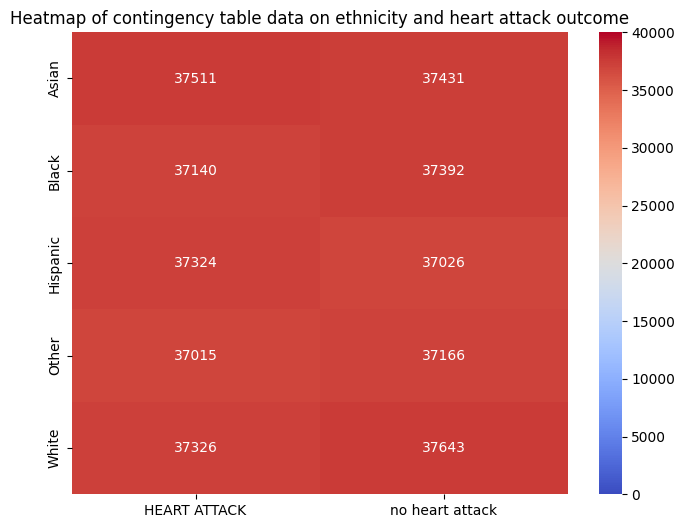

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnt, annot=True, fmt="d", cmap="coolwarm", vmin=0.0, vmax=40000.0)
plt.title("Heatmap of contingency table data on ethnicity and heart attack outcome")
plt.xticks([i+0.5 for i in range(cnt.shape[1])], ['HEART ATTACK', 'no heart attack'])
plt.yticks([i+0.5 for i in range(cnt.shape[0])], elmt[0])
plt.show()

seems quite even...

In [23]:

res = st.chi2_contingency(cnt, correction=False)
res.pvalue

np.float64(0.48306343081124736)

the chi square test gave a p value of 0.48 which is greater than the alpha of 0.05 so we fail to reject the null hypothesis.

### Exploration and Summary 2
By Josiah

I will write a two sided and two sample T test for my hypothesis test based on the independent groups of blood presssures of people that had a previous heart attack and blood pressures of people that did not have a previous heart attack. The alpha value will be 0.05.



- H0: There is no difference between the mean blood pressures of people that had a previous heart attack and the mean blood pressures of people that didn't have a previous heart attack.
- HA: There is a difference between the mean blood pressures of people that had a previous heart attack and the mean blood pressures of people that didn't have a previous heart attack.

If the ratio between the groups are less than 4:1 then we can consider the given groups to have equal variance.

In [24]:
previous_heart_attack = heart_attack_df[heart_attack_df['PreviousHeartAttack'] == True]['BloodPressure']
no_previous_heart_attack = heart_attack_df[heart_attack_df['PreviousHeartAttack'] == False]['BloodPressure']

print("Previous Heart Attack Variance: " + str(np.var(previous_heart_attack)))
print("No Previous Heart Attack Variance: " + str(np.var(no_previous_heart_attack)))

Previous Heart Attack Variance: 672.930726332723
No Previous Heart Attack Variance: 677.4239673804805


The ratio 677.424:672.931 is less than the 4:1 ratio which allows us to assume a same variance.

In [25]:
# Two sided and two sample T test
stat, p_value = scipy.stats.ttest_ind(a=previous_heart_attack, b=no_previous_heart_attack, equal_var=True)

print("P Value: " + str(p_value))

P Value: 0.21653200354387594


The p-value of 0.217 > alpha value of 0.05, so we fail to reject the null hypothesis that there is no difference between the mean blood pressures of people that had a previous heart attack and the mean blood pressures of people that didn't have a previous heart attack.

Text(0, 0.5, 'Blood Pressure (mmHg)')

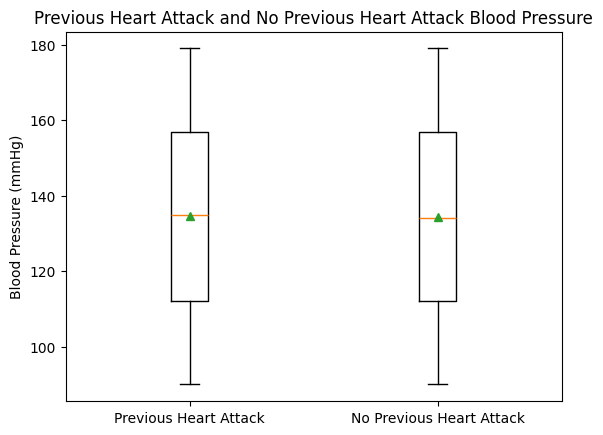

In [26]:
plt.boxplot([previous_heart_attack, no_previous_heart_attack], tick_labels=["Previous Heart Attack", "No Previous Heart Attack"], showmeans=True)
plt.title('Previous Heart Attack and No Previous Heart Attack Blood Pressure')
plt.ylabel('Blood Pressure (mmHg)')

This plots boxplots for the two groups. Note that the green triangles represent the mean and the red line represents the median.

### Exploration and Summary 3
By Kai

I will write a new hypothesis test based on four categorical variables, thus, I will be using ANOVA tests.

The following is a hypothesis test for whether the marital status has an effect on the outcome of a heart attack. (Assume $\alpha=0.05$).

- H0: The marital status does not have an effect on the outcome of whether one has a heart attack (i.e., they're independent).

- HA: The martial status does have an effect on the outcome of whether one has a heart attack.

I will first split the data into 4 different dataframes based on marital status.

In [27]:
# to tell me what the categorical variables were
# heart_attack_df['MaritalStatus'].unique()

single = heart_attack_df['MaritalStatus'] == 'Single'
married = heart_attack_df['MaritalStatus'] == 'Married'
widowed = heart_attack_df['MaritalStatus'] == 'Widowed'
divorced = heart_attack_df['MaritalStatus'] == 'Divorced'

# store the proportions of 'No Heart Attack' and 'Heart Attack'
single_proportion = heart_attack_df[single]['Outcome'].value_counts(normalize=True)
married_proportion = heart_attack_df[married]['Outcome'].value_counts(normalize=True)
widowed_proportion = heart_attack_df[widowed]['Outcome'].value_counts(normalize=True)
divorced_proportion = heart_attack_df[divorced]['Outcome'].value_counts(normalize=True)

display([single_proportion, married_proportion, widowed_proportion, divorced_proportion])

[Outcome
 No Heart Attack    0.500347
 Heart Attack       0.499653
 Name: proportion, dtype: float64,
 Outcome
 Heart Attack       0.500894
 No Heart Attack    0.499106
 Name: proportion, dtype: float64,
 Outcome
 No Heart Attack    0.501075
 Heart Attack       0.498925
 Name: proportion, dtype: float64,
 Outcome
 No Heart Attack    0.5013
 Heart Attack       0.4987
 Name: proportion, dtype: float64]

Next, I will use an ANOVA test called the one-way ANOVA test, which tests the null hypothesis that two or more groups have the same population proportion, and will have the test yield a p-value.

This hypothesis test is one of the only ways to test multiple categorical variables.

In [28]:
# ANOVA test
anova_test = scipy.stats.f_oneway(single, married, widowed, divorced)

anova_test.pvalue

np.float64(0.13990700149902488)

I will create a bar chart to show the relationship between marital status and the outcome of whether one has a heart attack.

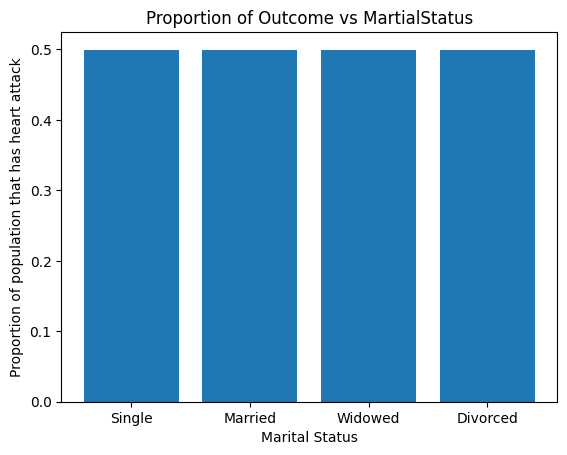

In [29]:
x_var = np.array(['Single', 'Married', 'Widowed', 'Divorced'])
y_var = np.array([single_proportion.iloc[1], married_proportion.iloc[1], widowed_proportion.iloc[1], divorced_proportion.iloc[1]])

plt.bar(x_var, y_var)
plt.title('Proportion of Outcome vs MartialStatus')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of population that has heart attack')
plt.show()

Since the p-value = 0.14 > (alpha = 0.05), we fail to reject the null hypothesis.

### Exploration and Summary 4
By Nathaniel

Conducting a hypothesis test to determine whether or not level of cholesterol has an effect on the outcome of a heart attack. 

For the purposes of this test,  I will assume the population standard deviation is unknown. Therefore I will use a two-sample T-test with level of significance $\alpha=0.05$.

- H0: Above-average cholesterol does not have an effect on the outcome of whether a heart attack occured
- HA: Above-average cholesterol does have an effect on the outcome of whether a heart attack occured.

To conduct this test, the data is split into two samples based on whether or not cholesterol is above the mean of the sample:

In [30]:
#convert object type data to numeric for stats.ttest_ind()
heart_attack_df['outcome_numeric'] = heart_attack_df['Outcome'].map({'No Heart Attack': 0, 'Heart Attack': 1})

mean = heart_attack_df['Cholesterol'].mean()

low_col_df = heart_attack_df[heart_attack_df['Cholesterol'] < mean]['outcome_numeric']
high_col_df = heart_attack_df[heart_attack_df['Cholesterol'] >= mean]['outcome_numeric']

In [31]:
t_stat, p_value = scipy.stats.ttest_ind(low_col_df, high_col_df, equal_var=False) 
p_value

np.float64(0.13103144828583682)

The p-value (0.131) >= 0.05, indicates no significant difference between the groups. We fail to reject the null hypothesis.

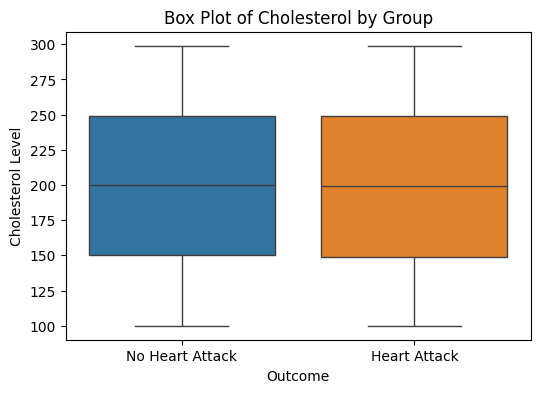

In [32]:
plt.figure(figsize=(6, 4))
plt.xlabel("Outcome")
plt.ylabel("Cholesterol Level")
plt.title("Box Plot of Cholesterol by Group")
sns.boxplot(x="Outcome", y="Cholesterol", data=heart_attack_df, hue="Outcome", legend=False)

plt.show()

(There appears to be little difference in the summary statistics for these two groups, thus resulting in the similar boxplots)

In [33]:
print(heart_attack_df.groupby("Outcome")["Cholesterol"].describe())

                    count        mean        std    min    25%    50%    75%  \
Outcome                                                                        
Heart Attack     186316.0  199.342504  57.758458  100.0  149.0  199.0  249.0   
No Heart Attack  186658.0  199.568976  57.688280  100.0  150.0  200.0  249.0   

                   max  
Outcome                 
Heart Attack     299.0  
No Heart Attack  299.0  


Below is a Bar plot that compares the number of those who had heart attacks with those that did not for individuals with above average Cholesterol.

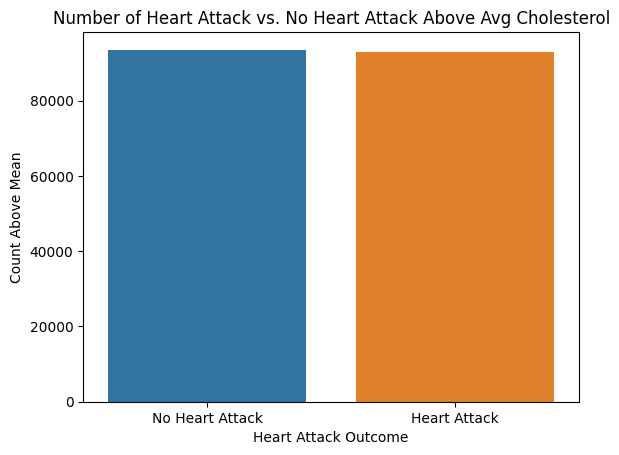

Outcome
No Heart Attack    93502
Heart Attack       92870
Name: count, dtype: int64

In [34]:
above_mean_df = heart_attack_df[heart_attack_df['Cholesterol'] > mean]

group_counts = above_mean_df['Outcome'].value_counts()

sns.barplot(x=group_counts.index, y=group_counts.values, hue=group_counts.index, legend=False)

plt.xlabel("Heart Attack Outcome")
plt.ylabel("Count Above Mean")
plt.title("Number of Heart Attack vs. No Heart Attack Above Avg Cholesterol")

plt.show()
group_counts

## ML Algorithm Design/Development

### ML Algorithm Design/Development

#### KNN Classifier
We are going to train a KNN classifier model in order to predict whether someone with a lot of unhealthy features (at least 5 unhealthy features) will get a heart attack or not.

In [ ]:
knn_model = KNeighborsClassifier()

# Perform k-fold Cross-Validation for the knn model
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# X should be all the features minus outcome, Y should be the outcome
X = for_ml_heart_attack_df.drop('Outcome', axis='columns')
Y = for_ml_heart_attack_df['Outcome']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Scaling the X data
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# check if knn model is accurate using training data and cross validation
cross_validation_accuracy = cross_val_score(knn_model, X_train, y_train, cv=skf)
print(f"Mean: {cross_validation_accuracy.mean()}")
print(f"Standard deviation: {cross_validation_accuracy.std()}")

# check if knn model is accurate using test data and cross validation
cross_validation_accuracy = cross_val_score(knn_model, X_test, y_test, cv=skf)
print(f"Mean: {cross_validation_accuracy.mean()}")
print(f"Standard deviation: {cross_validation_accuracy.std()}")

# now we see if our knn model predicts if someone with Kai's features will get a heart attack or not
knn_model.fit(X_train, y_train)
predict_kai = knn_model.predict(np.array([21, 0, 1, 130, 140, 70,
       21, 0, 0, 0, 0,
       2, 0, 0,
       1, 0, 3, 1, 0,
       0, 0, 0, 10000, 1, 0,
       0, 0, 0,
       0, 0,
       0, 0,
       0, 0, 180,
       0, 0, 0, 0,
       0, 2, 0,
       0, 0,
       0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1,
       0]).reshape(1, -1))

display("Kai will get a heart attack" if predict_kai == 1 else "Kai will not get a heart attack")

Mean: 0.5028906178547792
Standard deviation: 0.001325381831648938
Mean: 0.5018030699108519
Standard deviation: 0.003569700457296395


'Kai will get a heart attack'

If the cross-validation score of the mean is above 0.9 for both training and test data, then it has done well with the training data.

#### PCA (Primary Component Analysis)

Principal Component Analysis (PCA) is a dimensionality reduction technique that finds directions (principal components), maximizes variance in a dataset, reduces the number of features, we are improves the performance of an algorithm. But first!

#### Elbow Method
We need to use the elbow method to help found out the number of clusters needed to apply PCA.

Text(0.5, 1.0, 'Elbow Method')

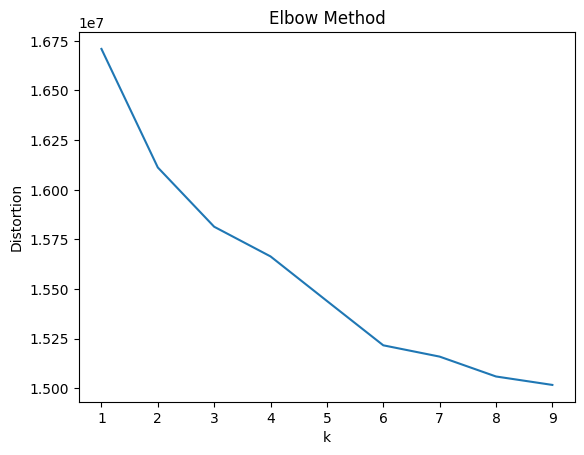

In [36]:
distortions = []
inertias = []
K = range(1, 10)

for k in K:
    # ANSWER STARTING HERE
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X_train)

    # get distortions and inertias
    distortions.append(sum(np.min(cdist(X_train, kmeans_model.cluster_centers_, metric='euclidean')**2, axis=1)))
    inertias.append(kmeans_model.inertia_)

plt.plot(K, distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method")

We'll choose k_cluster = 3 and move on to coding the PCA part.

[[-1.37371166  1.2608968 ]
 [-1.40896409  0.485607  ]
 [ 1.43433406 -0.31288811]
 ...
 [ 1.4189107  -1.02026116]
 [ 1.38404631  1.01575273]
 [-1.46298772  1.15957852]]
(372974, 2)
(372974,)


c:\Users\josep\anaconda3\envs\data\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


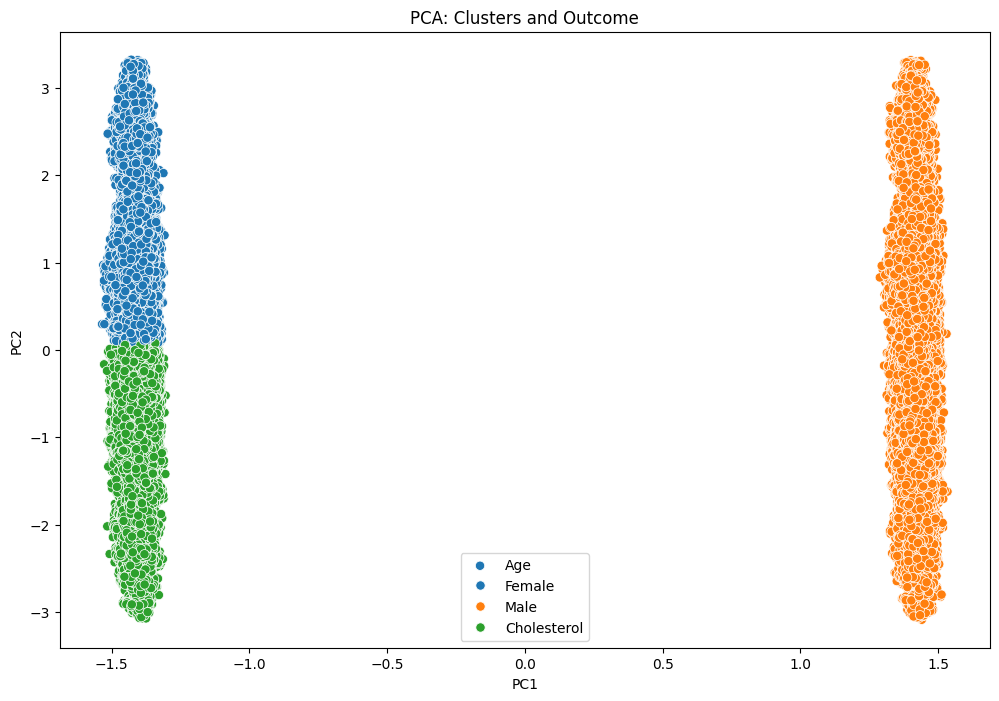

In [37]:
def apply_pca(X_scaled, n_components=2): # applies PCA and returns the PCA object and transformed data
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_scaled)
    return pca, X_pca

def apply_kmeans(X, n_clusters): # applies K-means clustering and return the cluster labels
    kmeans = KMeans(n_clusters, random_state=seed)
    labels = kmeans.fit_predict(X)
    return labels

seed = 42
k_cluster = 3
X_scaled = StandardScaler().fit_transform(X)
pca, X_pca = apply_pca(X_scaled)
pca_labels = apply_kmeans(X_pca, n_clusters = k_cluster) # Apply K-means to both PCA results
features = for_ml_heart_attack_df.columns.drop('Outcome').values

## Visualization

def plot_clusters(X, labels, rating, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(12, 8))
    kmeans = KMeans(n_clusters=k_cluster, random_state=seed).fit(X)
    for_ml_heart_attack_df['Cluster'] = pd.Categorical(kmeans.labels_)
    sns.scatterplot(x=X[:, 0],y=X[:, 1], hue="Cluster", data=for_ml_heart_attack_df,s=45,legend="full")
    plt.legend(labels=[features[0], features[1], features[2], features[3]])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

print(X_pca)
print(X_pca.shape)
print(for_ml_heart_attack_df['Outcome'].shape)

# Visualize PCA results
plot_clusters(X_pca, pca_labels, for_ml_heart_attack_df['Outcome'],
              'PCA: Clusters and Outcome', 'PC1', 'PC2')


### Joseph doing shit

In [51]:
pca.explained_variance_ratio_

array([3.57215461e-02, 2.69945443e-02, 2.69745825e-02, 2.69213997e-02,
       2.69147324e-02, 2.68676966e-02, 2.68298228e-02, 2.68193498e-02,
       2.67864417e-02, 2.67608659e-02, 2.67475612e-02, 2.66890982e-02,
       2.66286836e-02, 2.66250020e-02, 2.65389932e-02, 2.39055832e-02,
       2.38865486e-02, 2.38285270e-02, 2.37844947e-02, 2.37500893e-02,
       2.37094728e-02, 2.23413165e-02, 2.23235708e-02, 2.23060055e-02,
       2.22858098e-02, 1.80942554e-02, 1.80427758e-02, 1.80287657e-02,
       1.80144182e-02, 1.79688040e-02, 1.79498714e-02, 1.79306004e-02,
       1.79083747e-02, 1.78946602e-02, 1.78767769e-02, 1.78332189e-02,
       1.78206318e-02, 1.78124693e-02, 1.77642918e-02, 1.77580254e-02,
       1.77475932e-02, 1.76983779e-02, 1.76818194e-02, 1.76316352e-02,
       1.76008962e-02, 2.31606036e-14, 1.31692935e-14, 1.28358837e-14,
       9.73042548e-15, 8.13203515e-15, 4.21936034e-16, 4.21493099e-17,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

Text(0, 0.5, 'cumulative explained variance')

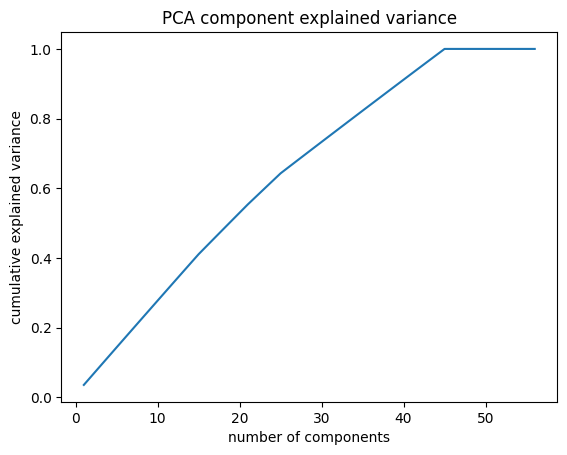

In [49]:


# def apply_pca(X_scaled, n_components=2): # applies PCA and returns the PCA object and transformed data
#     pca = PCA(n_components)
#     X_pca = pca.fit_transform(X_scaled)
#     return pca, X_pca


seed = 42
# k_cluster = 3
X_scaled = StandardScaler().fit_transform(X)

pca = PCA()
# X_pca = pca.fit_transform(X_scaled)
pca.fit(X_scaled)

# pca, X_pca = apply_pca(X_scaled)
# pca.explained_variance_ratio_

plt.figure()
plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum())

plt.title("PCA component explained variance")
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")



uhhhh not good. this shows that there isnt any good single thing that explains varaince well. At least better than nothing

Text(0.5, 1.0, 'Elbow Method')

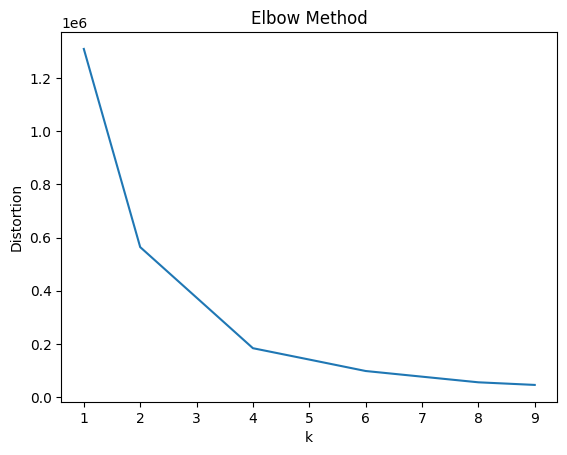

In [56]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


distortions = []
inertias = []
K = range(1, 10)

for k in K:
    # ANSWER STARTING HERE
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X_pca)

    # get distortions and inertias
    distortions.append(sum(np.min(cdist(X_pca, kmeans_model.cluster_centers_, metric='euclidean')**2, axis=1)))
    inertias.append(kmeans_model.inertia_)

plt.plot(K, distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title("Elbow Method")

i choose 2 as elbow ig

c:\Users\josep\anaconda3\envs\data\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


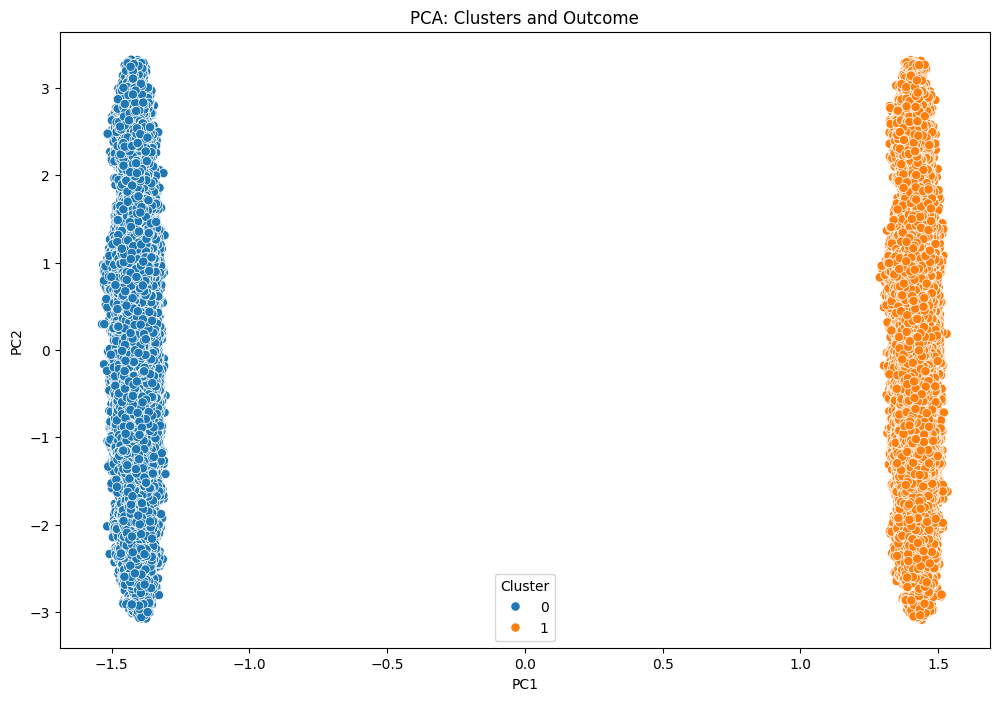

In [60]:
def plot_clusters(X, labels, rating, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(12, 8))
    kmeans = KMeans(n_clusters=2, random_state=seed).fit(X)
    for_ml_heart_attack_df['Cluster'] = pd.Categorical(kmeans.labels_)
    sns.scatterplot(x=X[:, 0],y=X[:, 1], hue="Cluster", data=for_ml_heart_attack_df,s=45,legend="full")
    # plt.legend(labels=[features[0], features[1], features[2], features[3]])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_clusters(X_pca, pca_labels, for_ml_heart_attack_df['Outcome'],
              'PCA: Clusters and Outcome', 'PC1', 'PC2')

ngl ts kinda pointless with how bad pca does here. perhaps the dataset rly is bugged...

In [61]:
components = pca.components_
features = X.columns
pca_loadings = pd.DataFrame(components, columns=features)
pca_loadings

,Age,Female,Male,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,PhysicalActivity,AlcoholConsumption,Diet_Healthy,Diet_Moderate,Diet_Unhealthy,StressLevel,Asian,Black,Hispanic,Other,White,Income,College,High School,Postgraduate,Medication,ChestPainType_Asymptomatic,ChestPainType_Atypical,ChestPainType_Non-anginal,ChestPainType_Typical,ECGResults_LV hypertrophy,ECGResults_Normal,ECGResults_ST-T abnormality,MaxHeartRate,ST_Depression,ExerciseInducedAngina,Downsloping,Flat,Upsloping,NumberOfMajorVessels,Thalassemia_Fixed defect,Thalassemia_Normal,Thalassemia_Reversible defect,PreviousHeartAttack,StrokeHistory,Rural,Suburban,Urban,Employed,Retired,Unemployed,Divorced,Married,Single,Widowed
0,0.001653,0.706881,-0.706881,0.001042,0.004311,-0.002556,-0.004198,-0.001934,-0.002017,-0.000815,-0.001744,-0.000955,-0.002825,0.005679,-0.006995,0.001330,0.004165,0.000966,-0.001082,0.001813,0.001732,-0.003418,0.002401,0.001741,-0.005888,0.004157,0.003714,-0.001300,0.000094,-0.002579,0.003786,0.00162,-0.002141,0.000519,-0.001653,-0.004374,0.003360,0.007793,-0.001576,-0.006211,0.002022,-0.007709,0.003970,0.003727,0.000940,-0.002749,0.005035,-0.006255,0.001226,-0.004423,0.002435,0.001983,-0.000470,0.003215,-0.000594,-0.002144
1,-0.000031,0.001505,-0.001505,-0.002377,-0.001867,0.002198,0.002283,0.005537,-0.002732,0.000632,0.003023,-0.002601,0.000080,0.114508,-0.070525,-0.043869,0.001470,-0.003443,-0.011855,-0.003626,0.015027,0.003918,-0.003366,-0.411940,0.465049,-0.053924,-0.002847,0.008892,0.010012,0.005133,-0.024055,-0.11194,0.024207,0.087861,0.006021,-0.000681,-0.000649,-0.060148,-0.024916,0.085031,-0.003697,-0.294521,0.491062,-0.197722,0.000901,-0.000568,-0.115687,0.025522,0.090222,0.140160,-0.333480,0.193326,-0.002129,-0.006587,0.004795,0.003900


wowies the first pca was basically just gender while the second one was a comb of employment , education, and thalassemia.

because k means basically only learned a clustering that is basically identical to gender which is already a feature, doing this did not add any additional information. We will not be adding the resulting clustering as an additional feature.